In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import (precision_recall_curve,PrecisionRecallDisplay)
from sklearn.metrics import precision_score,recall_score
from sklearn import metrics 
import seaborn as sns
import os 
import matplotlib.patches as mpatches
from nlcd_user import *
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from matplotlib.colors import ListedColormap
color_algo={'SVR':(0.8941176470588235, 0.10196078431372557, 0.10980392156862737),'ANN':(0.21568627450980393, 0.4941176470588236, 0.7215686274509804),'CIT':(0.3019607843137256, 0.6862745098039216, 0.29019607843137263),'KRR':(0.5960784313725492, 0.3058823529411765, 0.6392156862745098)}

In [7]:
# new function 
def calculate_precision_recall(causal,ind,causal_id=None,indep_id=None):
    #print("using new function, python inbuilt")
    precision=[]
    recall=[]
    presultscausal=pd.read_csv(causal)
    if causal_id:
        presultscausal=presultscausal.iloc[causal_id,]
    presultscausal=presultscausal.iloc[:,:-2]
    presultscausal.insert(0,column='GroundTruth',value=[1]*len(presultscausal))
    presultsind=pd.read_csv(ind)
    if indep_id:
        presultsind=presultsind.iloc[indep_id,]
    presultsind=presultsind.iloc[:,:-2]
    presultsind.insert(0,column='GroundTruth',value=[0]*len(presultsind))
    pMix=pd.concat([presultscausal,presultsind],ignore_index=True)
    if 'p_cit' in pMix.columns:
        pMix.rename(columns={'p_cit':'p_final'}, inplace=True)
    gt=pMix['GroundTruth']
    pred=pMix['p_final']
    mask = ~np.isnan(pred)
    gt=gt[mask]
    pred=pred[mask]
    pred=1-pred  # taking 1 minus , because in our case lesser the p-value, the better. but in the curve function higher the better
    #the function returns decreasing recall values so find the first precision and extend it 
    precision,recall,thresholds=precision_recall_curve(gt,pred,pos_label=1)
    precision[-1]=precision[-2]
    return precision,recall

        

In [4]:
def make_table(causal,ind,causal_id=None,indep_id=None,newfunc=True):
    precision=[]
    recall=[]
    TN=[]
    FN=[]
    FP=[]
    TP=[]
    presultscausal=pd.read_csv(causal)
    if causal_id:
        presultscausal=presultscausal.iloc[causal_id,]
    presultscausal=presultscausal.iloc[:,:-2]
    presultscausal.insert(0,column='GroundTruth',value=[1]*len(presultscausal))
    presultsind=pd.read_csv(ind)
    if indep_id:
        presultsind=presultsind.iloc[indep_id,]
    presultsind=presultsind.iloc[:,:-2]
    presultsind.insert(0,column='GroundTruth',value=[0]*len(presultsind))
    pMix=pd.concat([presultscausal,presultsind],ignore_index=True)
    if 'p_cit' in pMix.columns:
        pMix.rename(columns={'p_cit':'p_final'}, inplace=True)
    if newfunc==True:
        print("using new function")
        gt=pMix['GroundTruth']
        pred=pMix['p_final']
        mask = ~np.isnan(pred)
        gt=gt[mask]
        pred=pred[mask]
        pred=1-pred  # taking 1 minus , because in our case lesser the p-value, the better. but in the curve function higher the better
        #the function returns decreasing recall values so find the first precision and extend it 
        precision,recall,thresholds=precision_recall_curve(gt,pred,pos_label=1)
        #remove the last value from precision and recall 
        precision.resize(precision.size-1)
        recall.resize(recall.size-1)
        table=pd.DataFrame(np.column_stack([1-thresholds,precision,recall]),columns=['p_cutoffs','precision','recall'])
        table=table.sort_values(['p_cutoffs'])
    else:
        print("Using old function")
        # removing NaN values, CIT might throw up some NaN values 
        uniq_val=np.unique(pMix['p_final'])
        uniq_val = uniq_val[~np.isnan(uniq_val)]
        for j in range(0,len(uniq_val)):
            i=uniq_val[j]
            #if j==0:  ## extrapolate to the left side 
            #    pMix['results']=pMix.apply (lambda row: 1 if row['p_final'] <=i   else 0, axis=1)
            #    precision.append(precision_score(pMix['GroundTruth'],pMix['results']))
            #    recall.append(0)
            pMix['results']=pMix.apply (lambda row: 1 if row['p_final'] <=i   else 0, axis=1)
            confusion_matrix = metrics.confusion_matrix(pMix['GroundTruth'], pMix['results']) 
            TN.append(confusion_matrix[0][0])
            FN.append(confusion_matrix[1][0])
            FP.append(confusion_matrix[0][1])
            TP.append(confusion_matrix[1][1])
            precision.append(precision_score(pMix['GroundTruth'],pMix['results']))
            recall.append(recall_score(pMix['GroundTruth'],pMix['results']))

        table=pd.DataFrame(np.column_stack([uniq_val,TP,FP,TN,FN,precision,recall]),columns=['p cutoffs','TP','FP','TN','FN','precision','recall'])

            
    return table

In [5]:
def make_ranking_table(causal,ind):
    presultscausal=pd.read_csv(causal)
    if 'p_cit' in presultscausal.columns:
        presultscausal.rename(columns={'p_cit':'p_final'}, inplace=True)
    presultscausal.insert(0,column='GroundTruth',value=['causal']*len(presultscausal))
    presultsind=pd.read_csv(ind)
    if 'p_cit' in presultsind.columns:
        presultsind.rename(columns={'p_cit':'p_final'}, inplace=True)
    presultsind.insert(0,column='GroundTruth',value=['independent']*len(presultsind))
    presultscausal=presultscausal[['p_final','GroundTruth']]
    presultsind=presultsind[['p_final','GroundTruth']]
    finaltable=presultscausal.append(presultsind)
    finaltable.sort_values(['p_final'],inplace=True)
    
    return finaltable
    

In [10]:
def fig2_a():
    ####### figure 2 overlap depiction ############

    dflinear=read_data("./data/Linear500.txt") # going to read the data with the 52nd index 
    dfsine=read_data("./data/Sine500.txt") # going to read the data with the 54th index
    dfsaw=read_data("./data/Saw500.txt") # going to read the data with the 54th index 
    norows = 1
    nocols = 3

    fig, ax = plt.subplots(nrows=norows, ncols=nocols, sharey=True, figsize=(10, 4))
    fig.suptitle('Example plots for different datatypes')

    curr_ax = ax[0]
    plot_index = 0
    curr_ax.scatter(dflinear[52][1], dflinear[52][2], c=dflinear[52][0], cmap='viridis', alpha=0.6)
    curr_ax.axvspan(xmin=0.3, xmax=2, alpha=0.3, color='gray')  # Add shaded area
    curr_ax.set_xlabel('A')
    curr_ax.set_ylabel('B')
    curr_ax.set_title('Linear')
    # Create custom legend handles with correct colors
    unique_labels = set(dfsaw[54][0])
    num_labels = len(unique_labels)
    colors = plt.cm.get_cmap('viridis', num_labels)(range(num_labels))
    cmap = ListedColormap(colors)
    legend_handles = [mpatches.Patch(color=color, label=f'L={label}') for color, label in zip(colors, unique_labels)]

    # Create legend handles and labels for the shaded area
    shade_handle = mpatches.Patch(facecolor='gray', edgecolor='black', alpha=0.3, label='Shaded Area')

    # Combine legend handles and labels
    handles = legend_handles + [shade_handle]
    labels = ['L=0', 'L=1', 'Overlap']

    # Add the combined legend to the subplot
    curr_ax.legend(handles, labels, loc='lower right')

    curr_ax = ax[1]
    plot_index += 1
    curr_ax.scatter(dfsine[54][1], dfsine[54][2], c=dfsine[54][0], cmap='viridis', alpha=0.6)
    curr_ax.axvspan(xmin=0, xmax=2, alpha=0.3, color='gray')  # Add shaded area
    curr_ax.set_xlabel('A')
    curr_ax.set_ylabel('B')
    curr_ax.set_title('Sine')

    curr_ax = ax[2]
    plot_index += 1
    curr_ax.scatter(dfsaw[54][1], dfsaw[54][2], c=dfsaw[54][0], cmap='viridis', alpha=0.6)
    curr_ax.axvspan(xmin=0.3, xmax=2, alpha=0.3, color='gray')  # Add shaded area
    curr_ax.set_xlabel('A')
    curr_ax.set_ylabel('B')
    curr_ax.set_title('Saw')



    plt.tight_layout()
    plt.savefig("./results/journal/plots/fig2_example.png", bbox_inches='tight', dpi=1200)
    plt.savefig('./results/journal/plots/fig2_example.svg', bbox_inches='tight', format='svg', dpi=1200)

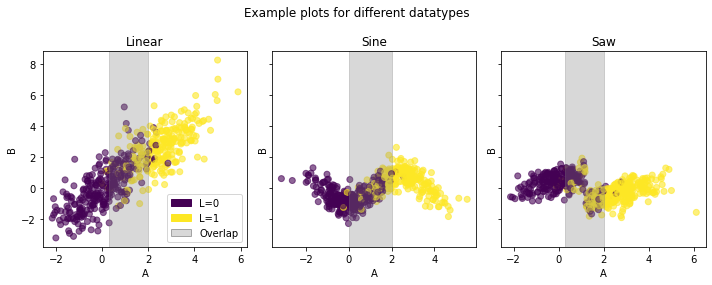

In [11]:
fig2_a()

In [31]:
def fig2_suppl_a():
    ### Figure 2 supplementary ################
    nlcd_dir="./results/journal/simulation/nlcd/"
    cit_dir="./results/journal/simulation/cit/"
    norows=3
    nocols=3
    fig, ax = plt.subplots(nrows=norows, ncols=nocols, sharex=True, sharey=True, figsize=(10,10))
    fig.suptitle("Precision-Recall Curve plots for 100 permutations ")
    #fig.text(0.5, 1, 'Precision-Recall Curve plots', ha='center')
    #fig.text(0.22, 1, 'Linear', ha='center')
    #fig.text(0.52, 1, 'Sine', ha='center')
    #fig.text(0.85, 1, 'Saw', ha='center')
    #fig.text(0,0.20, 'Sample size 1000', va='center', rotation='vertical')
    #fig.text(0,0.50, 'Sample size 500', va='center', rotation='vertical')
    #fig.text(0,0.79, 'Sample size 300', va='center', rotation='vertical')

    plot_index = 0

    for i in ['300', '500', '1000'] :
        for j in ['Linear', 'Sine', 'Saw']:
            for k in [ '100']: # put 100 permutations in supplementary 
                precision_nlmr_SVR, recall_nlmr_SVR = calculate_precision_recall(nlcd_dir + j + "SVR" + i + "s" + k + "perm.csv", nlcd_dir+"IndpSVR" + i + "s" + k + "perm.csv")
                precision_nlmr_KRR, recall_nlmr_KRR = calculate_precision_recall(nlcd_dir + j + "KRR" + i + "s" + k + "perm.csv", nlcd_dir+"IndpKRR" + i + "s" + k + "perm.csv")
                precision_nlmr_ANN, recall_nlmr_ANN = calculate_precision_recall(nlcd_dir + j + "ANN" + i + "s" + k + "perm.csv", nlcd_dir+"IndpANN" + i + "s" + k + "perm.csv")
                precision_CIT, recall_CIT = calculate_precision_recall(cit_dir + j + i + "cit" + k + "perm.csv", cit_dir+"Indp" + i + "cit" + k + "perm.csv")

                curr_ax = ax[plot_index // nocols, plot_index % nocols]
                
                #curr_ax.plot(recall_CIT,precision_CIT,color=color_algo['CIT'])
                #curr_ax.plot(recall_nlmr_ANN,precision_nlmr_ANN,color=color_algo['ANN'])
                #curr_ax.plot(recall_nlmr_SVR,precision_nlmr_SVR,color=color_algo['SVR'])
                #curr_ax.plot(recall_nlmr_KRR,precision_nlmr_KRR,color=color_algo['KRR'])
                disp = PrecisionRecallDisplay(precision=precision_nlmr_SVR, recall=recall_nlmr_SVR)
                disp.plot(ax=curr_ax, color=color_algo['SVR'])
                disp = PrecisionRecallDisplay(precision=precision_nlmr_ANN, recall=recall_nlmr_ANN)
                disp.plot(ax=curr_ax, color=color_algo['ANN'])
                disp = PrecisionRecallDisplay(precision=precision_CIT, recall=recall_CIT)
                disp.plot(ax=curr_ax, color=color_algo['CIT'])
                disp = PrecisionRecallDisplay(precision=precision_nlmr_KRR, recall=recall_nlmr_KRR)
                disp.plot(ax=curr_ax, color=color_algo['KRR'])
                curr_ax.set_ylabel('')
                curr_ax.set_xlabel('')
                if(plot_index // nocols == 0 and plot_index % nocols == 0):
                    curr_ax.set_title('Linear')
                elif(plot_index // nocols == 0 and plot_index % nocols == 1):
                    curr_ax.set_title('Sine')
                elif(plot_index // nocols == 0 and plot_index % nocols == 2):
                    curr_ax.set_title('Sawtooth')   
                if(plot_index % nocols == 0 and plot_index//norows==0):
                    curr_ax.set_ylabel('Sample size =300 \n Precision')
                if(plot_index % nocols == 0 and plot_index//norows==1):
                    curr_ax.set_ylabel('Sample size =500 \n Precision')
                if(plot_index % nocols == 0 and plot_index//norows==2):
                    curr_ax.set_ylabel('Sample size =1000 \n Precision')
                if(plot_index //nocols == (norows-1)):
                    curr_ax.set_xlabel('Recall')
                if(plot_index // nocols == norows-1 and plot_index % nocols == 0) :# if the plot is lower left, then add the legend in that plot
                    xindex=norows-1
                    yindex=0
                    handles = [ax[xindex, yindex].lines[3],ax[xindex,yindex].lines[2], ax[xindex, yindex].lines[1],ax[xindex, yindex].lines[0]]
                    labels = ['NLCD (KRR)','NLCD (SVR)', 'NLCD (ANN)',  'CIT (baseline)']
                    curr_ax.legend(handles,labels,loc="lower left")
            

                plot_index += 1

    fig.tight_layout()
    plt.savefig("./results/journal/plots/fig_2_suppl_a.png",bbox_inches='tight',dpi=1200)
    plt.savefig('./results/journal/plots/fig_2_suppl_a.svg', bbox_inches='tight',format='svg', dpi=1200)


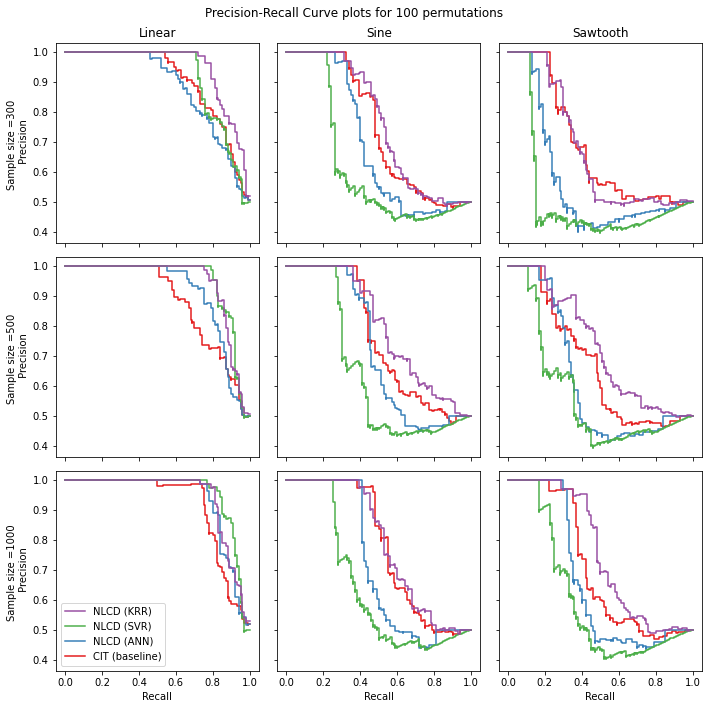

In [32]:
fig2_suppl_a()

In [39]:
def fig2_suppl_b():
    #### Figure 2 supplementary b ###########
    nlcd_dir='./results/journal/2way/'
    norows = 2
    nocols = 2
    fig, ax = plt.subplots(nrows=norows, ncols=nocols, sharex=True, sharey=True, figsize=(8, 7))
    fig.suptitle("Hex plot of p-values from A->B vs B->A p for NLCD(KRR) 100 permutations ")
    plot_index = 0

    for j in ['Linear', 'Sine', 'Saw', 'Indp']:
        dfcausal = pd.read_csv(nlcd_dir + j + 'KRR500s100perm.csv')
        dfrev = pd.read_csv(nlcd_dir + j + 'KRR500s100perm_rev.csv')
        curr_ax = ax[plot_index // nocols, plot_index % nocols]
        hb = curr_ax.hexbin(dfcausal['p_final'], dfrev['p_final'], gridsize=5, mincnt=1, cmap='Blues')
        
        if(plot_index == 0 or plot_index == 2):
            curr_ax.set_ylabel('B->A')
        else:
            curr_ax.set_ylabel('')
        curr_ax.set_xlabel('A->B ')
        
        if(j == 'Linear'):
            curr_ax.set_title('Linear')
        elif(j == 'Sine'):
            curr_ax.set_title('Sine')
        elif(j == 'Saw'):
            curr_ax.set_title('Sawtooth')
        elif(j == 'Indp'):
            curr_ax.set_title('Independent')
        
        plot_index += 1

    cbar_ax = fig.add_axes([0.93, 0.15, 0.03, 0.7])  # Adjust the position and size of the colorbar as needed
    cbar = fig.colorbar(hb, cax=cbar_ax)
    cbar.set_label('Counts')


    plt.savefig("./results/journal/plots/fig_2_suppl_b.png", bbox_inches='tight', dpi=1200)
    plt.savefig('./results/journal/plots/fig_2_suppl_b.svg', bbox_inches='tight', format='svg', dpi=1200)

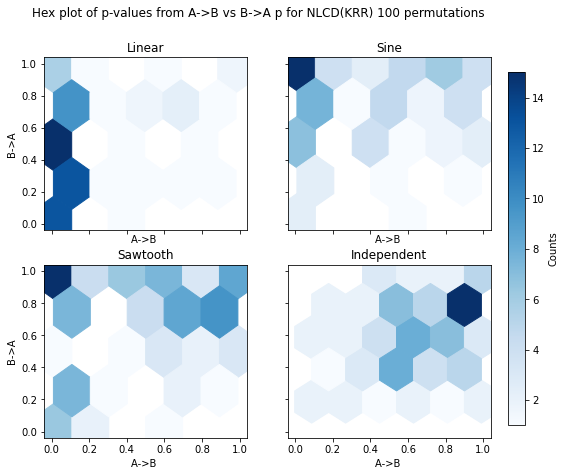

In [40]:
fig2_suppl_b()

In [41]:
def fig2_b():
    ### Figure 2 ################
    nlcd_dir="./results/journal/simulation/nlcd/"
    cit_dir="./results/journal/simulation/cit/"
    norows=3
    nocols=3
    fig, ax = plt.subplots(nrows=norows, ncols=nocols, sharex=True, sharey=True, figsize=(10,10))
    fig.suptitle("Precision-Recall Curve plots for 500 permutations ")
    plot_index = 0

    for i in ['300', '500', '1000'] :
        for j in ['Linear', 'Sine', 'Saw']:
            for k in [ '500']: # put 100 permutations in supplementary 
                precision_nlmr_SVR, recall_nlmr_SVR = calculate_precision_recall(nlcd_dir + j + "SVR" + i + "s" + k + "perm.csv", nlcd_dir+"IndpSVR" + i + "s" + k + "perm.csv")
                precision_nlmr_KRR, recall_nlmr_KRR = calculate_precision_recall(nlcd_dir + j + "KRR" + i + "s" + k + "perm.csv", nlcd_dir+"IndpKRR" + i + "s" + k + "perm.csv")
                precision_nlmr_ANN, recall_nlmr_ANN = calculate_precision_recall(nlcd_dir + j + "ANN" + i + "s" + k + "perm.csv", nlcd_dir+"IndpANN" + i + "s" + k + "perm.csv")
                precision_CIT, recall_CIT = calculate_precision_recall(cit_dir + j + i + "cit" + k + "perm.csv", cit_dir+"Indp" + i + "cit" + k + "perm.csv")

                curr_ax = ax[plot_index // nocols, plot_index % nocols]
        
                disp = PrecisionRecallDisplay(precision=precision_nlmr_SVR, recall=recall_nlmr_SVR)
                disp.plot(ax=curr_ax, color=color_algo['SVR'])#,marker='.') #https://matplotlib.org/2.1.2/api/_as_gen/matplotlib.pyplot.plot.html
                disp = PrecisionRecallDisplay(precision=precision_nlmr_ANN, recall=recall_nlmr_ANN)
                disp.plot(ax=curr_ax, color=color_algo['ANN'])
                disp = PrecisionRecallDisplay(precision=precision_CIT, recall=recall_CIT)
                disp.plot(ax=curr_ax, color=color_algo['CIT'])
                disp = PrecisionRecallDisplay(precision=precision_nlmr_KRR, recall=recall_nlmr_KRR)
                disp.plot(ax=curr_ax, color=color_algo['KRR'])
                curr_ax.set_ylabel('')
                curr_ax.set_xlabel('')
                # set datatype as titles 
                if(plot_index // nocols == 0 and plot_index % nocols == 0):        
                    curr_ax.set_title('Linear')
                elif(plot_index // nocols == 0 and plot_index % nocols == 1):
                    curr_ax.set_title('Sine')
                elif(plot_index // nocols == 0 and plot_index % nocols == 2):
                    curr_ax.set_title('Sawtooth')   
                if(plot_index % nocols == 0 and plot_index//norows==0):
                    curr_ax.set_ylabel('Sample size =300 \n Precision')
                if(plot_index % nocols == 0 and plot_index//norows==1):
                    curr_ax.set_ylabel('Sample size =500 \n Precision')
                if(plot_index % nocols == 0 and plot_index//norows==2):
                    curr_ax.set_ylabel('Sample size =1000 \n Precision')
                if(plot_index //nocols == (norows-1)): # if its the last row then add x labels 
                    curr_ax.set_xlabel('Recall')
                if(plot_index // nocols == norows-1 and plot_index % nocols == 0) :# if the plot is lower left, then add the legend in that plot
                    xindex=norows-1
                    yindex=0
                    handles = [ax[xindex, yindex].lines[3],ax[xindex,yindex].lines[2], ax[xindex, yindex].lines[1],ax[xindex, yindex].lines[0]]
                    labels = ['NLCD (KRR)','NLCD (SVR)', 'NLCD (ANN)',  'CIT (baseline)']
                    curr_ax.legend(handles,labels,loc="lower left")

                
                plot_index += 1

    #plt.tight_layout()
    # Create a common legend
    #handles = [ax[0, 0].lines[0], ax[0, 0].lines[1], ax[0, 0].lines[2], ax[0, 0].lines[3]]
    #labels = ['SVR', 'ANN', 'CIT', 'KRR']
    #fig.legend(handles, labels, loc='lower left')

    fig.tight_layout()
    plt.savefig("./results/journal/plots/fig2.png",bbox_inches='tight',dpi=1200)
    plt.savefig('./results/journal/plots/fig2.svg', bbox_inches='tight',format='svg', dpi=1200)


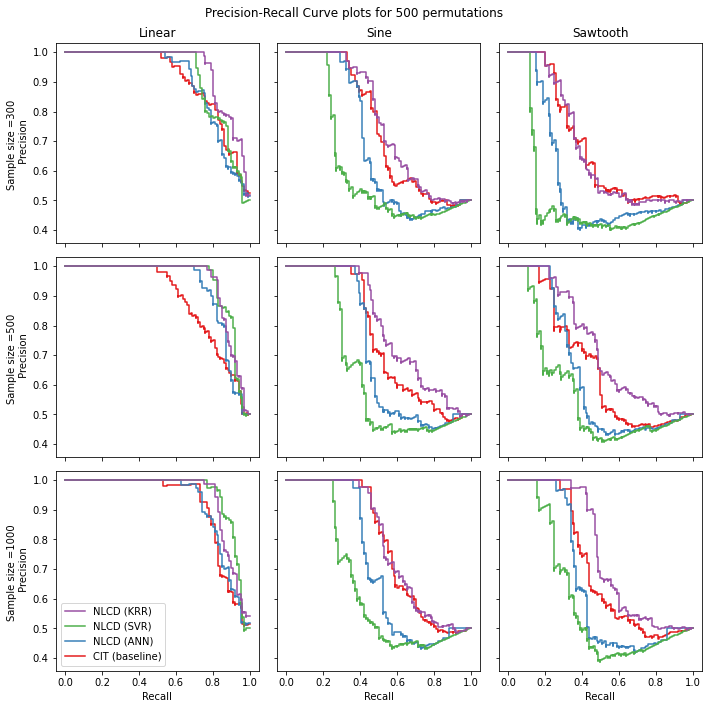

In [42]:
fig2_b()

In [51]:
def fig2_suppl_c():
    ### Figure 2 supplementary c c################
    nlcd_dir="./results/journal/10run/runvariation/nlcd/"
    cit_dir="./results/journal/10run/runvariation/cit/"
    norows=2
    nocols=3
    fig, ax = plt.subplots(nrows=norows, ncols=nocols, sharex=True, sharey=True, figsize=(8,5))
    fig.suptitle("PR curves for 10 runs ")

    plot_index = 0

    for k in [ '100','500']: 
        for j in ['Linear','Sine','Saw']:
            for i in ['1','2','3','4','5','6','7','8','9','10']:
                precision_nlmr_KRR, recall_nlmr_KRR = calculate_precision_recall(nlcd_dir+j+"KRR500s" + k +"perm"+i+"run"+".csv", nlcd_dir+"IndpKRR500s" + k + "perm"+i+"run"+".csv")
                precision_CIT, recall_CIT = calculate_precision_recall(cit_dir+j+"500cit" + k + "perm"+"run"+i+".csv", cit_dir+"Indp500cit" + k + "perm"+"run"+i+".csv")

                curr_ax = ax[ plot_index//nocols,plot_index % nocols]

                disp = PrecisionRecallDisplay(precision=precision_nlmr_KRR, recall=recall_nlmr_KRR)
                disp.plot(ax=curr_ax, color=color_algo['KRR'])#,marker='.') #https://matplotlib.org/2.1.2/api/_as_gen/matplotlib.pyplot.plot.html
                disp = PrecisionRecallDisplay(precision=precision_CIT, recall=recall_CIT)
                disp.plot(ax=curr_ax, color=color_algo['CIT'])  
                curr_ax.set_ylabel('')
                curr_ax.set_xlabel('')
            if(plot_index // nocols == 0 and plot_index % nocols == 0):
                curr_ax.set_title("Linear")
                curr_ax.set_ylabel("Permutations=100 \n Precision ")
            if(plot_index // nocols == 0 and plot_index % nocols == 1):
                curr_ax.set_title("Sine")
            if(plot_index // nocols == 0 and plot_index % nocols == 2):
                curr_ax.set_title("Sawtooth")
            if(plot_index // nocols == 1 ):
                if(plot_index % nocols == 0):
                    curr_ax.set_ylabel("Permutations=500 \n Precision")
                curr_ax.set_xlabel("Recall")
                
            if(plot_index // nocols == 1 and plot_index % nocols == 0) :
                xindex=norows-1
                yindex=0
                handles = [curr_ax.lines[0],curr_ax.lines[1]]
                labels = ['NLCD (KRR)','CIT (baseline)']
                curr_ax.legend(handles,labels,loc="lower left")
            
            plot_index += 1
        


    fig.tight_layout()
    plt.savefig("./results/journal/plots/fig_2_suppl_c.png",bbox_inches='tight',dpi=1200)
    plt.savefig('./results/journal/plots/fig_2_suppl_c.svg', bbox_inches='tight',format='svg', dpi=1200)


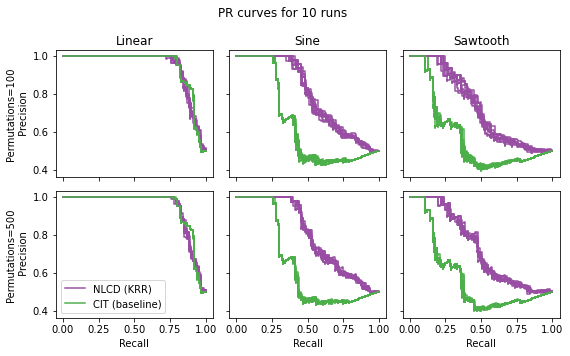

In [52]:
fig2_suppl_c()

In [49]:
def fig2_suppl_d():
    ### Figure 2 supplementary d ################
    nlcd_dir="./results/journal/10run/datavariation/nlcd/"
    cit_dir="./results/journal/10run/datavariation/cit/"
    norows=2
    nocols=3
    fig, ax = plt.subplots(nrows=norows, ncols=nocols, sharex=True, sharey=True, figsize=(8,5))
    fig.suptitle("PR curves for 10 different datasets ")

    plot_index = 0

    for k in [ '100','500']: 
        for j in ['Linear','Sine','Saw']:
            for i in ['1','2','3','4','5','6','7','8','9','10']:
                precision_nlmr_KRR, recall_nlmr_KRR = calculate_precision_recall(nlcd_dir+j+"KRR500s" + k +"perm"+i+"run"+".csv", nlcd_dir+"IndpKRR500s" + k + "perm"+i+"run"+".csv")
                precision_CIT, recall_CIT = calculate_precision_recall(cit_dir+j+"500cit" + k + "perm"+"run"+i+".csv", cit_dir+"Indp500cit" + k + "perm"+"run"+i+".csv")

                curr_ax = ax[ plot_index//nocols,plot_index % nocols]

                disp = PrecisionRecallDisplay(precision=precision_nlmr_KRR, recall=recall_nlmr_KRR)
                disp.plot(ax=curr_ax, color=color_algo['KRR'])#,marker='.') #https://matplotlib.org/2.1.2/api/_as_gen/matplotlib.pyplot.plot.html
                disp = PrecisionRecallDisplay(precision=precision_CIT, recall=recall_CIT)
                disp.plot(ax=curr_ax, color=color_algo['CIT'])
                #curr_ax.plot(recall_nlmr_KRR,precision_nlmr_KRR,color=color_algo['KRR'])
                #curr_ax.plot(recall_CIT,precision_CIT,color=color_algo['CIT'])    
                curr_ax.set_ylabel('')
                curr_ax.set_xlabel('')
            if(plot_index // nocols == 0 and plot_index % nocols == 0):
                curr_ax.set_title("Linear")
                curr_ax.set_ylabel("Permutations=100 \n Precision")
            if(plot_index // nocols == 0 and plot_index % nocols == 1):
                curr_ax.set_title("Sine")
            if(plot_index // nocols == 0 and plot_index % nocols == 2):
                curr_ax.set_title("Sawtooth")
            if(plot_index // nocols == 1 ):
                if(plot_index % nocols == 0):
                    curr_ax.set_ylabel("Permutations=500 \n Precision")
                curr_ax.set_xlabel("Recall")
                
            if(plot_index // nocols == 1 and plot_index % nocols == 0) :
                xindex=norows-1
                yindex=0
                handles = [curr_ax.lines[0],curr_ax.lines[1]]
                labels = ['NLCD (KRR)','CIT (baseline)']
                curr_ax.legend(handles,labels,loc="lower left")
            
            plot_index += 1
        


    fig.tight_layout()
    plt.savefig("./results/journal/plots/fig_2_suppl_d.png",bbox_inches='tight',dpi=1200)
    plt.savefig('./results/journal/plots/fig_2_suppl_d.svg', bbox_inches='tight',format='svg', dpi=1200)


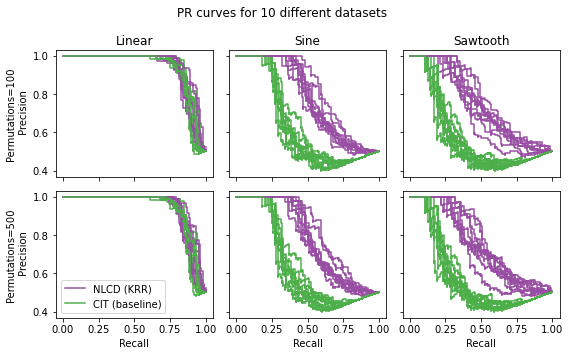

In [50]:
fig2_suppl_d()

In [43]:
def fig3_a():
    ### Figure 3 variance plot #################### 
    nlcd_dir="./results/journal/simulation/nlcd/"
    cit_dir="./results/journal/simulation/cit/"
    norows=2
    nocols=2
    fig, ax = plt.subplots(nrows=norows, ncols=nocols, sharex=True, sharey=True, figsize=(10,10))
    fig.suptitle("Performance when the variance changes for sample size of 500 ")
    #fig.text(0.5, 1, 'Precision-Recall Curve plots', ha='center')
    #fig.text(0.22, 1, 'Linear', ha='center')
    #fig.text(0.52, 1, 'Sine', ha='center')
    #fig.text(0.85, 1, 'Saw', ha='center')
    #fig.text(0,0.20, 'Sample size 1000', va='center', rotation='vertical')
    color_purple  = sns.color_palette("Purples", 3)
    color_green = sns.color_palette("Greens", 3)

    #fig.text(0,0.27, 'Same variance', va='center', rotation='vertical')
    #fig.text(0,0.71, 'Different variance', va='center', rotation='vertical')
    plot_index = 0

    for j in ['Linearvar', 'Paravar','Linear','Para']:
        col_indx=0
        curr_ax = ax[plot_index // nocols, plot_index % nocols]
        #for i in ['300', '500', '1000'] :
        for i in ['500']:
            for k in [ '100']: 
                precision_nlmr_KRR, recall_nlmr_KRR = calculate_precision_recall(nlcd_dir + j + "KRR" + i + "s" + k + "perm.csv", nlcd_dir+"IndpKRR" + i + "s" + k + "perm.csv")
                precision_CIT, recall_CIT = calculate_precision_recall(cit_dir + j + i + "cit" + k + "perm.csv", cit_dir+"Indp" + i + "cit" + k + "perm.csv")
                #curr_ax.plot(recall_CIT,precision_CIT,color=color_algo['CIT'])
                #curr_ax.plot(recall_nlmr_KRR,precision_nlmr_KRR,color=color_algo['KRR'])
                disp = PrecisionRecallDisplay(precision=precision_CIT, recall=recall_CIT)
                disp.plot(ax=curr_ax, color=color_algo['CIT'])
                disp = PrecisionRecallDisplay(precision=precision_nlmr_KRR, recall=recall_nlmr_KRR)
                disp.plot(ax=curr_ax, color=color_algo['KRR'])
                curr_ax.set_ylabel('')
                curr_ax.set_xlabel('')
                # set datatype as titles 
                if(plot_index // nocols == 0 and plot_index % nocols == 0):        
                    curr_ax.set_title('Linear')
                elif(plot_index // nocols == 0 and plot_index % nocols == 1):
                    curr_ax.set_title('Parabola')
                if(plot_index == 0):   # if its the second row then add the y labels 
                    curr_ax.set_ylabel('Different variance \n Precision')
                if(plot_index == 2):
                    curr_ax.set_ylabel("Same variance \n Precision")
                if(plot_index //nocols == (norows-1)): # if its the last row then add x labels 
                    curr_ax.set_xlabel('Recall')
                col_indx += 1
        if(plot_index // nocols == norows-1 and plot_index % nocols == 0) :# if the plot is lower left, then add the legend in that plot
            xindex=norows-1
            yindex=0
            handles = [ax[xindex, yindex].lines[0], ax[xindex, yindex].lines[1]]
            labels = ['CIT','NLCD (KRR)']
            curr_ax.legend(handles,labels,loc="lower left")
            
                
        
        plot_index+=1

    fig.tight_layout()
    plt.savefig("./results/journal/plots/fig3_var.png",bbox_inches='tight',dpi=1200)
    plt.savefig('./results/journal/plots/fig3_var.svg', bbox_inches='tight',format='svg', dpi=1200)


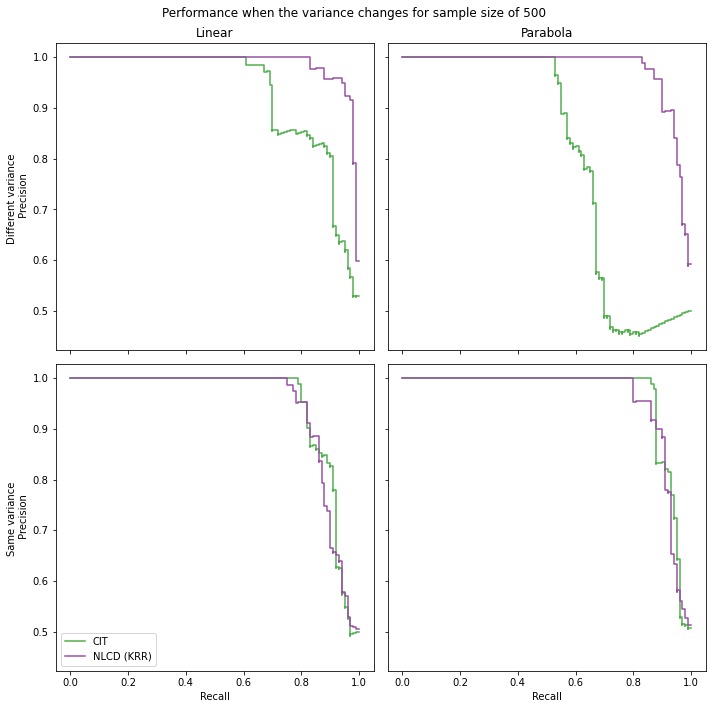

In [44]:
fig3_a()

In [45]:
def fig3_suppl():
    #### Figure 3 supplementary ######
    nlcd_dir="./results/journal/simulation/nlcd/"
    cit_dir="./results/journal/simulation/cit/"
    norows=2
    nocols=2
    fig, ax = plt.subplots(nrows=norows, ncols=nocols, sharex=True, sharey=True, figsize=(10,10))
    fig.suptitle("Performance when the variance changes for sample sizes of 300 and 1000 ")
    color_purple  = sns.color_palette("Purples", 2)
    color_green = sns.color_palette("Greens", 2)
    plot_index = 0

    for j in ['Linearvar', 'Paravar','Linear','Para']:
        col_indx=0
        curr_ax = ax[plot_index // nocols, plot_index % nocols]
        for i in ['300', '1000'] :
        #for i in ['500']:
            for k in [ '100']: 
                precision_nlmr_KRR, recall_nlmr_KRR = calculate_precision_recall(nlcd_dir + j + "KRR" + i + "s" + k + "perm.csv", nlcd_dir+"IndpKRR" + i + "s" + k + "perm.csv")
                precision_CIT, recall_CIT = calculate_precision_recall(cit_dir + j + i + "cit" + k + "perm.csv", cit_dir+"Indp" + i + "cit" + k + "perm.csv")
                #curr_ax.plot(recall_CIT,precision_CIT,color=color_green[col_indx])

                disp = PrecisionRecallDisplay(precision=precision_CIT, recall=recall_CIT)
                disp.plot(ax=curr_ax, color=color_green[col_indx])
                disp = PrecisionRecallDisplay(precision=precision_nlmr_KRR, recall=recall_nlmr_KRR)
                disp.plot(ax=curr_ax, color=color_purple[col_indx])
                #curr_ax.plot(recall_nlmr_KRR,precision_nlmr_KRR,color=color_purple[col_indx])
                curr_ax.set_ylabel('')
                curr_ax.set_xlabel('')
                # set datatype as titles 
                if(plot_index // nocols == 0 and plot_index % nocols == 0):        
                    curr_ax.set_title('Linear')
                elif(plot_index // nocols == 0 and plot_index % nocols == 1):
                    curr_ax.set_title('Parabola')
                if(plot_index % nocols == 0):   # if its the second row then add the y labels 
                    curr_ax.set_ylabel('Precision')
                if(plot_index % nocols == 0 and plot_index // norows  == 0):  
                    curr_ax.set_ylabel('Different Variance \n Precision')
                if(plot_index % nocols == 0 and plot_index // norows  == 1):  
                    curr_ax.set_ylabel('Same Variance \n Precision')
                if(plot_index //nocols == (norows-1)): # if its the last row then add x labels 
                    curr_ax.set_xlabel('Recall')
                col_indx += 1
        if(plot_index // nocols == norows-1 and plot_index % nocols == 0) :# if the plot is lower left, then add the legend in that plot
            xindex=norows-1
            yindex=0
            handles = [ax[xindex, yindex].lines[1], ax[xindex, yindex].lines[3],ax[xindex, yindex].lines[0], ax[xindex, yindex].lines[2]]
            labels = ['NLCD (300)','NLCD (1000)','CIT (300)','CIT (1000)']
            curr_ax.legend(handles,labels,loc="lower left")
            
                
        
        plot_index+=1

    fig.tight_layout()
    plt.savefig("./results/journal/plots/fig3_var_suppl.png",bbox_inches='tight',dpi=1200)
    plt.savefig('./results/journal/plots/fig3_var_suppl.svg', bbox_inches='tight',format='svg', dpi=1200)


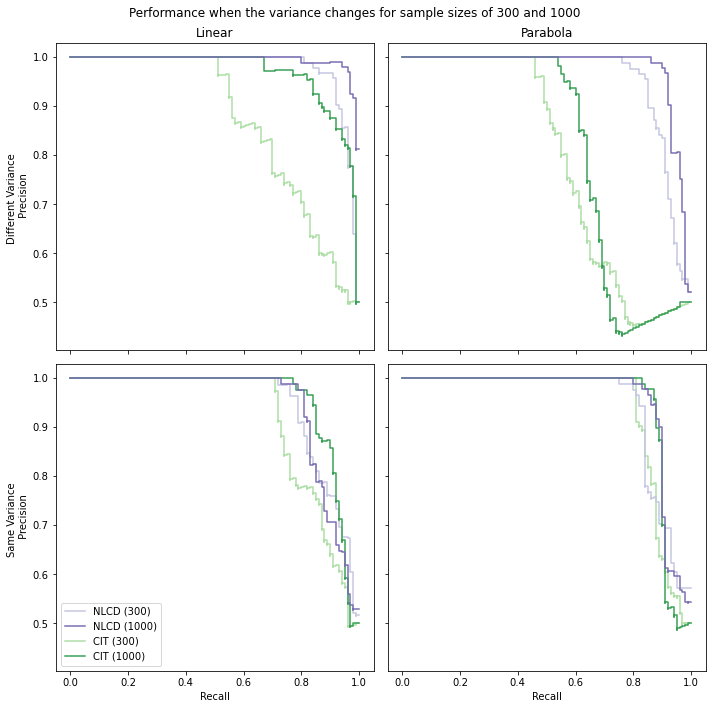

In [46]:
fig3_suppl()

In [47]:
def fig4():

    norows=4
    nocols=3
    nlcd_dir='./results/journal/simulation/nlcd/'
    cit_dir='./results/journal/simulation/cit/'
    fig, ax = plt.subplots(nrows=norows, ncols=nocols, sharex=True, sharey=True, figsize=(10,10))
    fig.suptitle("Tests comparison of NLCD vs CIT p-values : 500 sample size , 500 permutations ")
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    for plot_index in [0,3,6,9]:
        if plot_index==0:
            x = 'p_LassocB'
            y = 'p_TL'
        elif plot_index==3:
            x='p_LassocA|B'
            y='p_GL'
        elif plot_index==6:
            x='p_AassocB|L'
            y='p_TG'
        elif plot_index==9:
            x='p_LindB|A'
            y='p_Lind'
        for j in ['Linear', 'Sine', 'Saw']: 
                    

            curr_ax = ax[plot_index // nocols, plot_index % nocols]
            curr_ax.set_ylabel('')
            curr_ax.set_xlabel('')
            dfnlcd=pd.read_csv(nlcd_dir+j+'KRR500s500perm.csv')
            dfcit=pd.read_csv(cit_dir+j+'500cit500perm.csv') 
            hb=curr_ax.hexbin(dfnlcd[x], dfcit[y], gridsize=5,mincnt=1, cmap='Blues')
            if(plot_index//nocols == 0 and plot_index % nocols ==1 ):
                curr_ax.set_xlabel('<----------NLCD L ~ B---------->')
            if(plot_index//nocols == 1 and plot_index % nocols ==1 ):
                curr_ax.set_xlabel('<----------NLCD L ~ A|B-------->')
            if(plot_index//nocols == 2 and plot_index % nocols ==1 ):
                curr_ax.set_xlabel('<----------NLCD A ~ B|L-------->')
            if(plot_index//nocols == 3 and plot_index % nocols ==1 ):
                curr_ax.set_xlabel(r'<----------NLCD L $\bot$ B|A-------->')

            if(plot_index // nocols == 0 and plot_index % nocols == 0):
                curr_ax.set_title('Linear')
            elif(plot_index // nocols == 0 and plot_index % nocols == 1):
                curr_ax.set_title('Sine')
            elif(plot_index // nocols == 0 and plot_index % nocols == 2):
                curr_ax.set_title('Sawtooth')   
            if(plot_index % nocols == 0 and plot_index//nocols == 0):
                curr_ax.set_ylabel(' CIT L ~ B')
            if(plot_index % nocols == 0 and plot_index//nocols == 1 ):
                curr_ax.set_ylabel(' CIT L ~ A|B')
            if(plot_index % nocols == 0 and plot_index // nocols == 2):
                curr_ax.set_ylabel(' CIT A ~ B|L')
            if(plot_index % nocols == 0 and plot_index // nocols == 3):
                curr_ax.set_ylabel(r' CIT L $\bot$ B|A')
            
            

            plot_index += 1

    cbar = fig.colorbar(hb, cax=cbar_ax)
    cbar.set_label('Counts')

    plt.savefig("./results/journal/plots/fig_7_suppl.png",bbox_inches='tight',dpi=1200)
    plt.savefig('./results/journal/plots/fig_7_suppl.svg', bbox_inches='tight',format='svg', dpi=1200)

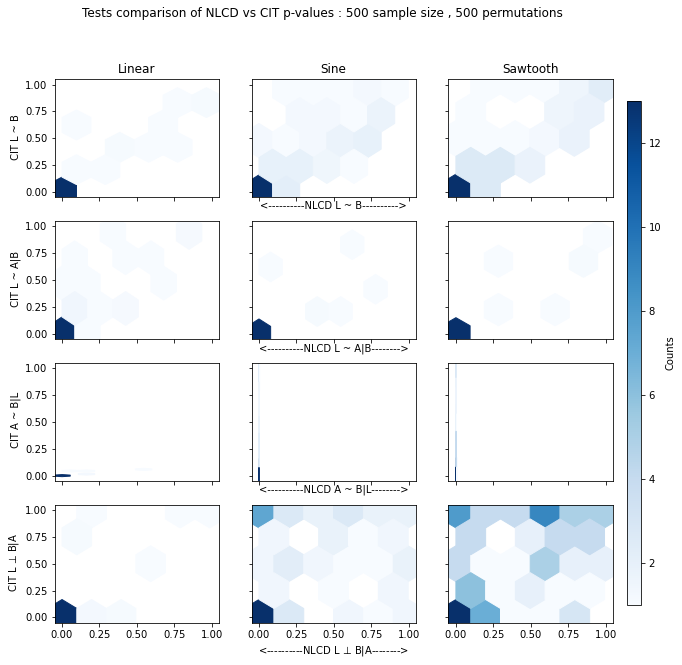

In [48]:
fig4()

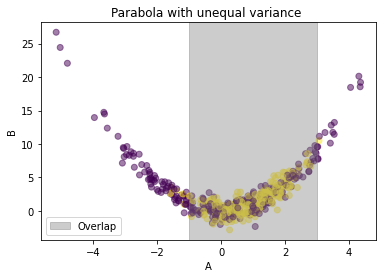

In [28]:
df=read_data('./data/Paravar500.txt')
i=4
A=df[i][1]
B=df[i][2]
L=df[i][0]
plt.scatter(A,B,c=L,alpha=0.5)
plt.title("Parabola with unequal variance ")
plt.xlabel('A')
plt.ylabel('B')
plt.axvspan(xmin=-1, xmax=3, alpha=0.4, color='gray',label='Overlap') 
plt.legend()

plt.savefig("./results/journal/plots/fig3_example.png",bbox_inches='tight',dpi=1200)
plt.savefig('./results/journal/plots/fig3_example.svg', bbox_inches='tight',format='svg', dpi=1200)

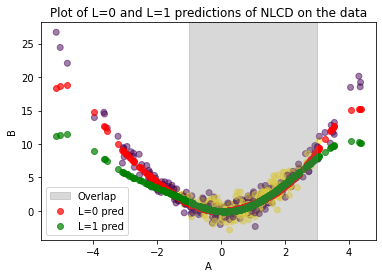

In [30]:
# Parabola 500: i=4 for example 
plt.title("Plot of L=0 and L=1 predictions of NLCD on the data")
plt.scatter(A,B,c=L,alpha=0.5)
plt.xlabel('A')
plt.ylabel('B')
y_pred_original=compute_Luniqs_predns(L,A,B,'KRR')
plt.scatter(A,y_pred_original[0],label='L=0 pred',alpha=0.7,color='red')
plt.scatter(A,y_pred_original[1],label='L=1 pred',alpha=0.7,color='green')
plt.axvspan(xmin=-1, xmax=3, alpha=0.3, color='gray',label='Overlap') 
plt.legend()
plt.savefig("./results/journal/plots/fig3_example_L.png",bbox_inches='tight',dpi=1200)
plt.savefig('./results/journal/plots/fig3_example_L.svg', bbox_inches='tight',format='svg', dpi=1200)